# POPMAX AF
During the meeting on the 16.3.2023,it was suggested to filter variants by the allle frequency (AF) of the population which the variant is most common in (popmax in gnomAD terms) <br>

in order to do so, I rerun the pipeline with few changes, the script can be found [here](code/get_gnomAD_POPMAX_AF.sh) <br>
the script run with the following command-
```bash 
 sbatch --array=0-23 -o slurm_log/gnomAD_AF_2003_%A_%a.log --mem 500G -c 16 -t 56:00:00 --wrap "code/get_gnomAD_POPMAX_AF.sh"
 ```
 Some chromosome did not finshed properly due to not enough memory. I did a rerun for each one of them with more memory, until the process finished properly for all <br>
 
 In the new files, the popmax AF and regular AF is avaiable. <br>
 I'll run a sanity check to see that all the variants which exist in the current file, can be foind in the output of the new pipeline

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np

In [2]:
chrom_list = ['chr1', "chr2", "chr4","chr3","chr5", "chr6", "chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19", "chr20", "chr21", "chr22", "chrX", "chrY"]
def get_chrom_variant(chrom, new=True):
    """
    opens the new generated AF variant file 
    """
    if new:
        df = pd.read_csv(f'data/gnomAD_popmax_AF/{chrom}_gnomAD_AF_19_03.tsv',
                         sep='\t',
                         header=None,
                        names= ['CHROM','POS','REF','ALT','AF', 'popmax_AF', 'filter'])
    else:
        df = pd.read_csv(f'data/gnomAD_AF/{chrom}_gnomAD_AF.tsv',
                         sep='\t',
                         header=None).loc[:,:4]
        df.columns = ['CHROM','POS','REF','ALT','AF']
    return df.set_index(['CHROM','POS','REF','ALT'])


def add_gnomAD_link(df):
    df = df.reset_index()
    links = []
    for i, row in df.iterrows():
        links.append(f"https://gnomad.broadinstitute.org/variant/{row.CHROM.replace('chr','')}-{row.POS}-{row.REF}-{row.ALT}?dataset=gnomad_r3")
    df['gnomAD'] = links
    func = lambda x: x if len(x) <= 5 else x[:5] + '...'
    df.REF = df.REF.apply(func)
    df.ALT = df.ALT.apply(func)
    return df


def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

def show_table(df):
    df = add_gnomAD_link(df)
    display(df.style.format({'gnomAD': make_clickable}))

In [3]:
old_AF = pd.concat([ get_chrom_variant(chrom, new=False) for chrom in chrom_list])
show_table(old_AF.head())
new_AF  = pd.concat([ get_chrom_variant(chrom, new=True) for chrom in chrom_list])
show_table(new_AF.head())

,CHROM,POS,REF,ALT,AF,gnomAD
0,chr1,29231,GC,G,0.000235,https://gnomad.broadinstitute.org/variant/1-29231-GC-G?dataset=gnomad_r3
1,chr1,29253,C,T,0.000009,https://gnomad.broadinstitute.org/variant/1-29253-C-T?dataset=gnomad_r3
2,chr1,29257,TC,T,0.000019,https://gnomad.broadinstitute.org/variant/1-29257-TC-T?dataset=gnomad_r3
3,chr1,29257,TCCCC...,T,0.000009,https://gnomad.broadinstitute.org/variant/1-29257-TCCCCTACTTCGCCCCGCCAGGC-T?dataset=gnomad_r3
4,chr1,29267,C,G,0.000016,https://gnomad.broadinstitute.org/variant/1-29267-C-G?dataset=gnomad_r3


/cs/usr/toozig/my_python/lib/python3.7/site-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


,CHROM,POS,REF,ALT,AF,popmax_AF,filter,gnomAD
0,chr1,29210,A,G,0.000263,0.00125313,AS_VQSR,https://gnomad.broadinstitute.org/variant/1-29210-A-G?dataset=gnomad_r3
1,chr1,29215,C,T,0.000000,.,AC0;AS_VQSR,https://gnomad.broadinstitute.org/variant/1-29215-C-T?dataset=gnomad_r3
2,chr1,29216,G,A,0.000054,0.00118483,AS_VQSR,https://gnomad.broadinstitute.org/variant/1-29216-G-A?dataset=gnomad_r3
3,chr1,29218,T,C,0.000120,0.00522648,AS_VQSR,https://gnomad.broadinstitute.org/variant/1-29218-T-C?dataset=gnomad_r3
4,chr1,29219,C,T,0.000000,.,AC0;AS_VQSR,https://gnomad.broadinstitute.org/variant/1-29219-C-T?dataset=gnomad_r3


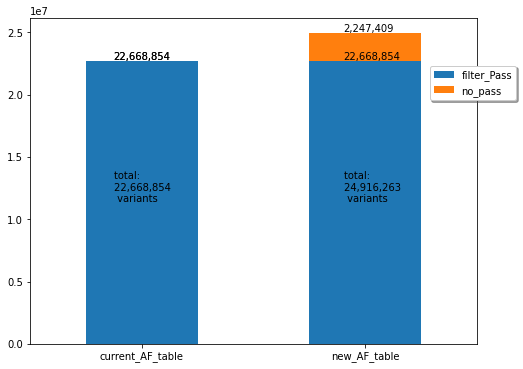

In [4]:
plot_df = pd.DataFrame({'filter_Pass': [old_AF.shape[0],
                        new_AF[new_AF['filter'].str.contains('PASS')].shape[0]],
  'no_pass': [0, new_AF[~new_AF['filter'].str.contains('PASS')].shape[0],]},
  index = ['current_AF_table', 'new_AF_table'])

ax = plot_df.plot(kind = 'bar', stacked = True, figsize = (8, 6), rot=0)
cur_p =  ax.patches[0]
# annotatating the plot
ax.annotate(f'{int(cur_p.get_height()):,}',
                (cur_p.get_x() * 0.505,
                 cur_p.get_height() * 1.005))
ax.annotate(f'total: \n{int(old_AF.shape[0]):,} \n variants' ,
                (cur_p.get_x() * 0.505,
                 cur_p.get_height() * 1.005 / 2))

ax.annotate(f'{int(cur_p.get_height()):,}',
                (cur_p.get_x() * 0.505,
                 cur_p.get_height() * 1.005))

new_p = ax.patches[1]
ax.annotate(f'{int(new_p.get_height()):,}',
            (new_p.get_x() * 1.205,
            new_p.get_height() * 1.005))

new_p = ax.patches[1]
ax.annotate(f'total: \n{int(new_AF.shape[0]):,} \n variants ',
            (new_p.get_x() * 1.205,
            new_p.get_height() * 1.005 / 2))

non_fil_ax = ax.patches[3]
ax.annotate(f'{int(non_fil_ax.get_height()):,}',
            (non_fil_ax.get_x() * 1.205,
            new_p.get_height() * 1.005 + non_fil_ax.get_height() * 1.005))
x = ax.legend(loc='right',bbox_to_anchor=(1.1, 0.8),
          fancybox=True, shadow=True)


The plot above show the amount of variants in the current used gnomAD AF table (the left bar) and the amount of variants in the new AF table (which contains the popmax AF). <br>
The later contains more variants due to additional variants which did not pass the quality control.  <br>
the numbers shows the same amount of variants which did pass the filter (22,668,854, blue). with additional 2,247,409   in the new table. <br>
the new table contains another column, 'filter', which describe if the variant passed the filter ('PASS') or in which filtertaion the variant failed. description of the filters can be found [here](https://gnomad.broadinstitute.org/news/2019-10-gnomad-v3-0/) <br>

Next I'll checck if there is a difference between the AF of the new table and the current.<br>
a summry statistics of the difference in AF is shown below-

In [5]:
(old_AF.AF - new_AF[new_AF['filter'] == 'PASS'].AF.astype(float)).describe().rename('diffrence between new and current AF') 

count    22668854.0
mean            0.0
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             0.0
Name: diffrence between new and current AF, dtype: float64

Both tables have the same AF for each variants (the general AF, not popmax) <br>
***Therefore I consider the new table legit***

## popmax  AF vs general AF

In the following part I'll compare between the popmax AF and the general AF, such that we will get a notion what to expect from the analysis. I'll use only variants which passed gnomAD filteration

In [13]:
passed_v = new_AF[new_AF['filter'] == 'PASS']
passed_v.loc[:,'popmax_AF'] = passed_v.popmax_AF.replace('.',np.nan).astype('float')

show_table(passed_v.head())

/cs/usr/toozig/my_python/lib/python3.7/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,CHROM,POS,REF,ALT,AF,popmax_AF,filter,gnomAD
0,chr1,29231,GC,G,0.000235,0.000717,PASS,https://gnomad.broadinstitute.org/variant/1-29231-GC-G?dataset=gnomad_r3
1,chr1,29253,C,T,0.000009,nan,PASS,https://gnomad.broadinstitute.org/variant/1-29253-C-T?dataset=gnomad_r3
2,chr1,29257,TC,T,0.000019,0.000041,PASS,https://gnomad.broadinstitute.org/variant/1-29257-TC-T?dataset=gnomad_r3
3,chr1,29257,TCCCC...,T,0.000009,nan,PASS,https://gnomad.broadinstitute.org/variant/1-29257-TCCCCTACTTCGCCCCGCCAGGC-T?dataset=gnomad_r3
4,chr1,29267,C,G,0.000016,0.000054,PASS,https://gnomad.broadinstitute.org/variant/1-29267-C-G?dataset=gnomad_r3


For some reason, the minimal AF described in the table is 6.56547e-06, when the AF is lower, it's written NaN.<br>
3% of the variants have nan in thier popmax column. <br>
in order to continue with the analysis, I'll replace np.nan with the minimal AF value.


In [50]:
passed_v = passed_v.replace(np.nan, passed_v[['AF','popmax_AF']].astype(float).min().min())
plot_df = passed_v[['AF','popmax_AF']].astype(float)
plot_df.describe()

,AF,popmax_AF
count,2.266885e+07,2.266885e+07
mean,4.141386e-03,6.442932e-03
std,4.518580e-02,5.736595e-02
min,6.565470e-06,1.469330e-05
25%,6.571860e-06,1.515980e-05
50%,6.955460e-06,4.825790e-05
75%,2.628470e-05,1.940240e-04
max,1.000000e+00,1.000000e+00


The following shows a higher AF mean but a lower median of the popmax. 